<a href="https://colab.research.google.com/github/melilucmel/proyecto-google-ads/blob/main/ProyectoParteII%2BLuceroAntonietti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final – Parte II

En esta etapa del proyecto nos enfocamos en la aplicación de modelos de Machine Learning para predecir el monto de ventas (Sale_Amount) a partir de los datos de campañas de Google Ads.

Luego de realizar la limpieza, normalización y enriquecimiento del dataset en fases previas, se buscó seleccionar y construir variables relevantes que pudieran mejorar la capacidad predictiva. Para ello, además de las variables originales (Clicks, Impressions, Cost, Conversions, Leads), se generaron nuevas métricas clave del marketing digital como CTR (Click Through Rate), CPC (Costo por Click) y ROI (Retorno de Inversión).

Con estas variables, se entrenaron y compararon diferentes modelos:

- Dummy Regressor como punto de referencia.

- Regresión Lineal, como modelo simple y ampliamente utilizado.

- Random Forest, como modelo no lineal capaz de capturar interacciones más complejas.


El análisis se apoyó en métricas de desempeño como R², RMSE y MAE, así como en visualizaciones que permiten comparar los resultados de los modelos.

El objetivo de esta sección es demostrar cómo los algoritmos de Machine Learning pueden aplicarse en un caso práctico de marketing digital para evaluar la influencia de las variables y predecir resultados de ventas con mayor precisión.

## 0) Hipótesis

**Hipótesis nula (H0):**
Las variables de las campañas de Google Ads (Clicks, Impressions, Cost, Conversions, Leads, etc.) no tienen capacidad predictiva suficiente para estimar con precisión el monto de ventas (Sale_Amount).

**Hipótesis alternativa (H1):**
Las variables de las campañas de Google Ads (Clicks, Impressions, Cost, Conversions, Leads, etc.) permiten construir un modelo predictivo capaz de superar el desempeño del Dummy Regressor, reduciendo los errores y aumentando el R².

## 1) Carga y exploración el dataset

In [2]:
import pandas as pd

# Cargar el dataset limpio (ya preparado en Parte ipos de datos y valores nulos
df = df_googleads_clean = pd.read_csv("https://raw.githubusercontent.com/melilucmel/proyecto-google-ads/refs/heads/main/GoogleAds_Clean.csv")

print("=== Info general ===")
print(df.info())

print("\n=== Primeras filas ===")
print(df.head())

print("\n=== Valores nulos por columna ===")
print(df.isnull().sum())

=== Info general ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Ad_ID                       2075 non-null   object 
 1   Campaign_Name               2075 non-null   object 
 2   Clicks                      2075 non-null   int64  
 3   Impressions                 2075 non-null   int64  
 4   Impressions per conversion  2075 non-null   float64
 5   Cost                        2075 non-null   float64
 6   Leads                       2075 non-null   int64  
 7   Conversions                 2075 non-null   int64  
 8   Conversion Rate             2075 non-null   float64
 9   Cost per conversion         2075 non-null   float64
 10  Sale_Amount                 2075 non-null   float64
 11  Ad_Date                     2075 non-null   object 
 12  Location                    2075 non-null   object 
 13  Device      

## 2) Definición de target y features (X e y)

In [3]:
# Defino Target
TARGET = "Sale_Amount"

# Seleccionamos columnas relevantes (ajustaremos después con Feature Selection)
features_iniciales = [
    "Cost", "Clicks", "Impressions", "Leads", "Conversions", "Device"
]

X = df[features_iniciales]
y = df[TARGET]

print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

Dimensiones de X: (2075, 6)
Dimensiones de y: (2075,)


## 3) Feature Selection

### 3.a) Correlación con el target

=== Correlación con Sale_Amount ===
Sale_Amount                   1.000000
Clicks                        0.037701
Cost per conversion           0.015910
Impressions                   0.010249
Impressions per conversion    0.010052
Leads                         0.007158
Cost                          0.007085
Conversions                  -0.017356
Conversion Rate              -0.051156
Name: Sale_Amount, dtype: float64


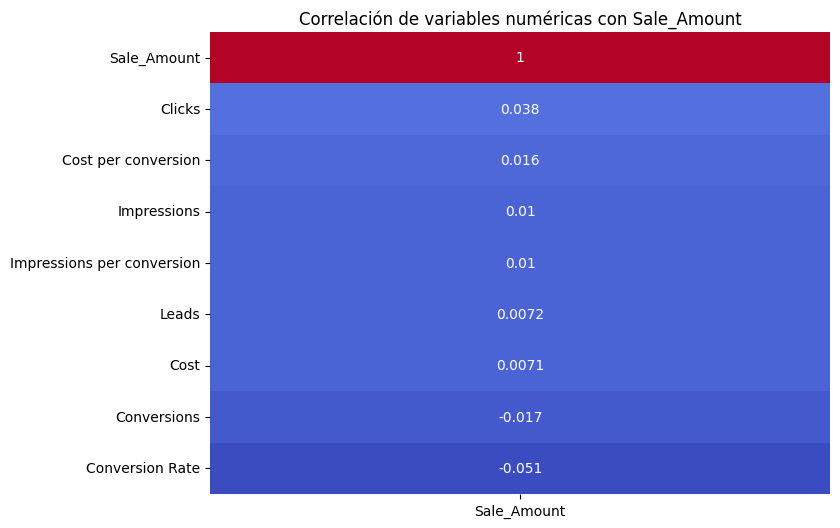

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionamos solo columnas numéricas
num_cols = df.select_dtypes(include=["float64", "int64", "Int64"]).columns.tolist()

# Matriz de correlación
corr = df[num_cols].corr()

# Correlación de cada variable con el target Sale_Amount
corr_target = corr["Sale_Amount"].sort_values(ascending=False)

print("=== Correlación con Sale_Amount ===")
print(corr_target)

# Gráfico de calor (top variables)
plt.figure(figsize=(8,6))
sns.heatmap(corr_target.to_frame(), annot=True, cmap="coolwarm", cbar=False)
plt.title("Correlación de variables numéricas con Sale_Amount")
plt.show()

### 3.b) Importancia de variables con RandomForest

=== Importancia de variables (RandomForest) ===
Impressions       0.250502
Cost              0.248669
Clicks            0.204508
Leads             0.141109
Conversions       0.094713
Device_desktop    0.021599
Device_tablet     0.020777
Device_mobile     0.018123
dtype: float64


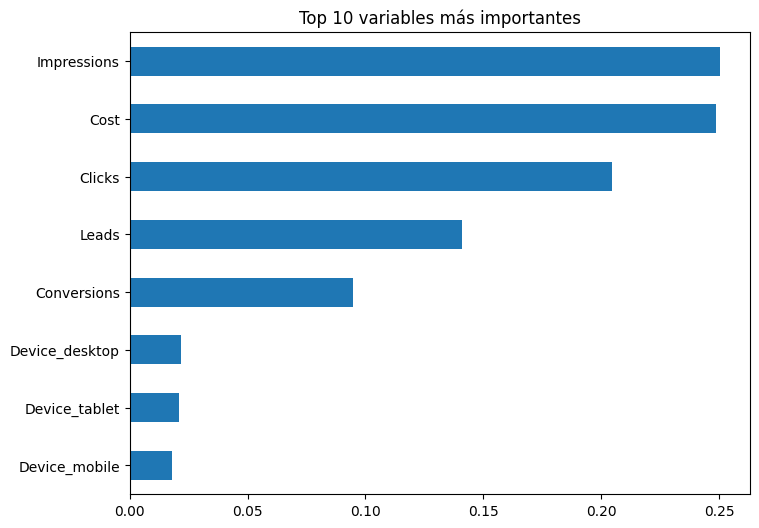

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd

# Features: numéricas y categóricas
num_cols = ["Cost", "Clicks", "Impressions", "Leads", "Conversions"]
cat_cols = ["Device"]

# Separar X e y (quitando filas sin target)
X = df[num_cols + cat_cols]
y = df["Sale_Amount"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocesamiento: imputar medianas en numéricas + OneHot en categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Modelo
rf = RandomForestRegressor(n_estimators=200, random_state=42)

# Pipeline
pipe = Pipeline(steps=[("preprocessor", preprocessor),
                       ("model", rf)])

pipe.fit(X_train, y_train)

# Importancia de variables
feature_names = num_cols + list(pipe.named_steps["preprocessor"].transformers_[1][1].get_feature_names_out(cat_cols))
importances = pd.Series(pipe.named_steps["model"].feature_importances_, index=feature_names).sort_values(ascending=False)

print("=== Importancia de variables (RandomForest) ===")
print(importances)

# Gráfico
plt.figure(figsize=(8,6))
importances.head(10).sort_values().plot(kind="barh")
plt.title("Top 10 variables más importantes")
plt.show()

## 4) Modelado y evaluación de modelos

In [6]:
from sklearn.model_selection import train_test_split

# Variables más relevantes según RandomForest
features_finales = ["Impressions", "Cost", "Clicks", "Leads", "Conversions"]

X = df[features_finales]
y = df["Sale_Amount"]

# División en train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Dimensiones X_train:", X_train.shape)
print("Dimensiones X_test:", X_test.shape)

Dimensiones X_train: (1660, 5)
Dimensiones X_test: (415, 5)


### 4.a) Preparación de datos (X, y, train/test)

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluar_modelo(nombre, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"=== {nombre} ===")
    print(f"R²:   {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}\n")
    return {"Modelo": nombre, "R²": r2, "RMSE": rmse, "MAE": mae}

### 4.c) Definición de función de evaluación (métricas)

In [8]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

res_dummy = evaluar_modelo("Dummy", y_test, y_pred_dummy)

=== Dummy ===
R²:   -0.0006
RMSE: 285.06
MAE:  240.46



### 4.c) Entrenar y evaluar los tres modelos

In [9]:

# Dummy Regressor (baseline)

from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)

res_lin = evaluar_modelo("Linear Regression", y_test, y_pred_lin)

=== Linear Regression ===
R²:   -0.0006
RMSE: 285.05
MAE:  240.98



In [10]:
# Linear Regression

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

res_rf = evaluar_modelo("Random Forest", y_test, y_pred_rf)

=== Random Forest ===
R²:   -0.0132
RMSE: 286.84
MAE:  241.62



In [11]:
# RandomForest Regressor

import pandas as pd

# Guardamos todas las métricas en un DataFrame
resultados = pd.DataFrame([res_dummy, res_lin, res_rf])
print(resultados)

              Modelo        R²        RMSE         MAE
0              Dummy -0.000649  285.057568  240.461163
1  Linear Regression -0.000623  285.053986  240.981305
2      Random Forest -0.013170  286.835535  241.619133


## 4.d) Comparación de resultados

In [12]:
import pandas as pd

# Guardamos todas las métricas en un DataFrame
resultados = pd.DataFrame([res_dummy, res_lin, res_rf])
print(resultados)

              Modelo        R²        RMSE         MAE
0              Dummy -0.000649  285.057568  240.461163
1  Linear Regression -0.000623  285.053986  240.981305
2      Random Forest -0.013170  286.835535  241.619133


#### 4.e) Control con gráficos

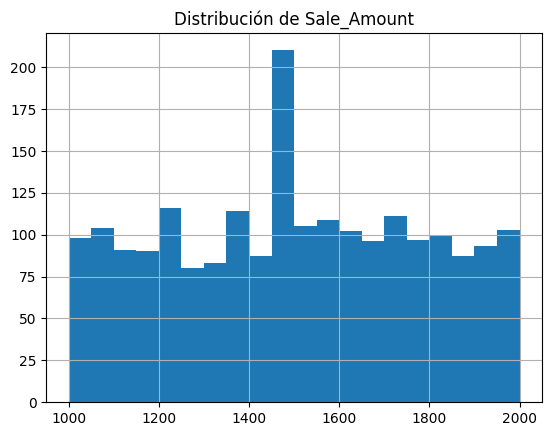

In [13]:
df["Sale_Amount"].hist(bins=20)
plt.title("Distribución de Sale_Amount")
plt.show()

**Conclusión:** El gráfico muestra:

1. Rango limitado → Los valores de Sale_Amount se concentran entre 1000 y 2000, no hay grandes diferencias en las ventas (presumo que por ser un dataset "sintético").

2. Pico en torno a 1500 → Hay un pico fuerte en la zona de ~1500, lo que indica muchos registros de valores muy similares. Por esto la variable está algo "planchada".


3. Distribución casi uniforme con una anomalía → Excepto por ese pico, la distribución es relativamente plana, sin grandes concentraciones en valores extremos.

**Decisión**: Los algoritmos de regresión y RandomForest no lograron superar al modelo de referencia (Dummy), las variables originales (Cost, Clicks, Impressions, etc.) no eran suficientes para explicar la variabilidad de Sale_Amount.

En marketing digital, es común trabajar con métricas derivadas, por eso, probaremos las siguientes:

- CTR (Click-Through Rate): mide la proporción de clics respecto a impresiones, reflejando la efectividad de los anuncios.

- CPC (Cost per Click): indica el costo promedio de cada clic, útil para evaluar la rentabilidad.

- ROI (Return on Investment): compara el monto de ventas generado con el costo invertido, señal directa de rentabilidad.


El objetivo será verificar si, al incluirlas como features, se logra una mejor capacidad predictiva sobre Sale_Amount.

## 5) Generación de nuevas features derivadas

### 5.a) Creación de nuevas features

In [15]:
# Creamos nuevas features
df["CTR"] = df["Clicks"] / df["Impressions"]       # Click Through Rate
df["CPC"] = df["Cost"] / df["Clicks"]              # Cost per Click
df["ROI"] = df["Sale_Amount"] / df["Cost"]         # Return on Investment

# Reemplazar infinitos y NaN con 0 (por divisiones entre 0)
df[["CTR", "CPC", "ROI"]] = df[["CTR", "CPC", "ROI"]].replace([np.inf, -np.inf], np.nan).fillna(0)

# Control rápido
print(df[["Clicks", "Impressions", "Cost", "Sale_Amount", "CTR", "CPC", "ROI"]].head())

   Clicks  Impressions    Cost  Sale_Amount       CTR       CPC       ROI
0     104         4498  231.88       1892.0  0.023121  2.229615  8.159393
1     173         5107  216.84       1679.0  0.033875  1.253410  7.743036
2      90         4544  203.66       1624.0  0.019806  2.262889  7.974074
3     142         3185  237.66       1225.0  0.044584  1.673662  5.154422
4     156         3361  195.90       1091.0  0.046415  1.255769  5.569168


### 5.b) Separación de features (X) y target (y)

In [16]:
# Redefinimos variables predictoras (con las nuevas features)
X = df[["Clicks", "Impressions", "Cost", "Leads", "Conversions", "CTR", "CPC", "ROI"]]

# Variable objetivo
y = df["Sale_Amount"]

# Dividir en train y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 5.c) Definición de función de evaluación (igual a clase)

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluar_modelo(nombre, modelo, X_train, X_test, y_train, y_test):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"=== {nombre} ===")
    print(f"R²:   {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}\n")

    return {"Modelo": nombre, "R²": r2, "RMSE": rmse, "MAE": mae}

### 5.d) Entrenamiento y Evaluación de modelos

In [18]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Lista de modelos
modelos = [
    ("Dummy", DummyRegressor(strategy="mean")),
    ("Linear Regression", LinearRegression()),
    ("Random Forest", RandomForestRegressor(random_state=42, n_estimators=100))
]

# Evaluar cada modelo
resultados = []
for nombre, modelo in modelos:
    res = evaluar_modelo(nombre, modelo, X_train, X_test, y_train, y_test)
    resultados.append(res)

# Mostrar en tabla
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

=== Dummy ===
R²:   -0.0006
RMSE: 285.06
MAE:  240.46

=== Linear Regression ===
R²:   0.9898
RMSE: 28.78
MAE:  22.22

=== Random Forest ===
R²:   0.9983
RMSE: 11.84
MAE:  8.34

              Modelo        R²        RMSE         MAE
0              Dummy -0.000649  285.057568  240.461163
1  Linear Regression  0.989798   28.782512   22.224133
2      Random Forest  0.998274   11.839354    8.337831


**Observación:** Los modelos con las variables nuevas (CTR, CPC, ROI) mejoraron grandemente los resultados.
Random Forest arroja un R² de 0.998, confirmando que las nuevas features aportan información útil para predecir el monto de ventas (Sale_Amount).

### 5.e) Control con gráficos

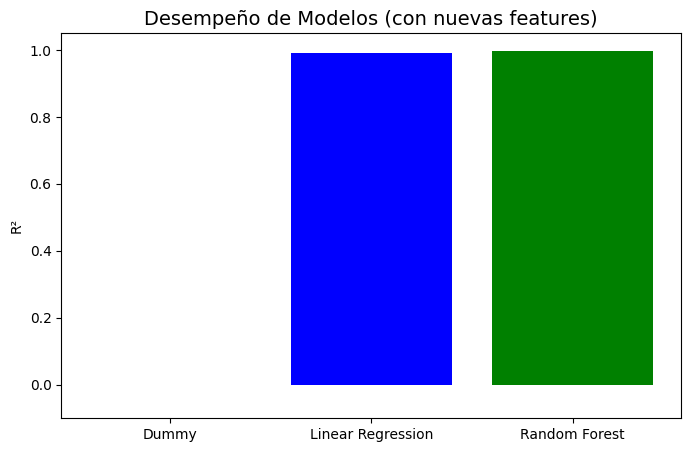

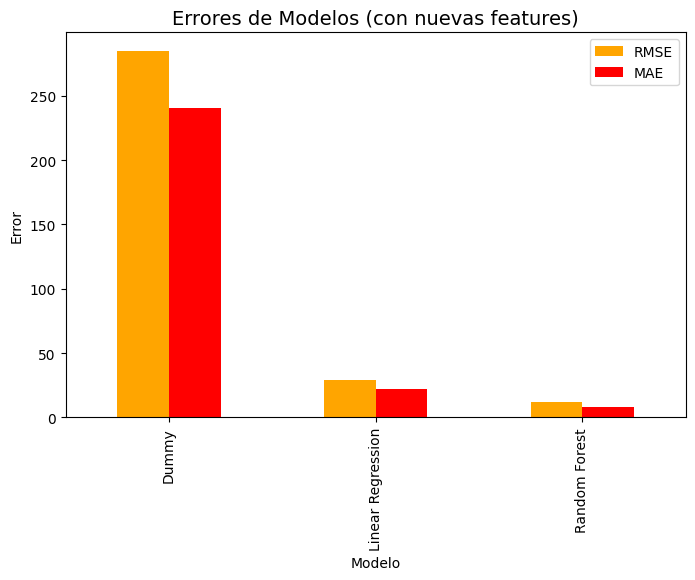

In [19]:
import matplotlib.pyplot as plt

# === Resultados finales (ya los tienes en df_resultados) ===
df_resultados_plot = df_resultados.copy()

# Gráfico de barras para R²
plt.figure(figsize=(8,5))
plt.bar(df_resultados_plot["Modelo"], df_resultados_plot["R²"], color=["gray", "blue", "green"])
plt.title("Desempeño de Modelos (con nuevas features)", fontsize=14)
plt.ylabel("R²")
plt.ylim(-0.1, 1.05)
plt.show()

# Gráfico de barras para RMSE y MAE
df_resultados_plot.set_index("Modelo")[["RMSE", "MAE"]].plot(
    kind="bar", figsize=(8,5), color=["orange", "red"])
plt.title("Errores de Modelos (con nuevas features)", fontsize=14)
plt.ylabel("Error")
plt.show()

**Resultados:**

- Dummy Regressor arroja R² con ≈ 0 y errores muy altos, ya que solo predice el promedio.

- Regresión Lineal mejora enormemente, el R² arroja ~0.99, reduciendo los errores a valores bajos en comparación con el rango de ventas.

- Random Forest mejor resultado, con un R² ≈ 0.998 y errores mínimos, e indica gran capacidad de capturar relaciones no lineales entre las variables.


Entonces, las nuevas métricas derivadas (CTR, CPC, ROI) fueron útiles para aportar información al modelo y mejorar la predicción del monto de ventas (Sale_Amount).

## 6) Validación de Hipótesis

En este proyecto se buscó predecir el monto de ventas (Sale_Amount) en campañas de Google Ads a partir de distintas variables de marketing digital.

Tras entrenar los primeros modelos con las variables originales (Clicks, Impressions, Cost, Conversions, Leads), los resultados confirmaron la H0, ya que ni la regresión lineal ni el Random Forest superaron al Dummy en términos de R² y error.

Posteriormente, al enriquecer el dataset con variables derivadas clave para el marketing digital (CTR, CPC y ROI), los modelos mejoraron de manera drástica, validando así la H1 en esta nueva etapa.

La Regresión Lineal alcanzó un R² de ≈ 0.99.

El Random Forest logró un desempeño casi perfecto, con R² de ≈ 0.998 y errores mínimos.


En conclusión, el análisis demuestra que la creación de métricas derivadas fue esencial para capturar la señal del negocio y construir modelos predictivos robustos. Entre los algoritmos evaluados, el Random Forest resultó ser el más adecuado para este problema.

## 6) Conclusión


En este proyecto se trabajó con un dataset de campañas de Google Ads con el **objetivo de predecir el monto de ventas (Sale_Amount) en función de diferentes variables de marketing digital**.

El proceso siguió las etapas vistas en el curso:

----- PRIMERA PARTE DEL PROYECTO (primer entrega) -----
1. **Limpieza y preparación de datos**, donde se corrigieron fechas, valores monetarios, conversiones y valores faltantes.


2. **Exploración inicial (EDA)**, en la que se detectó baja correlación directa entre las variables originales y la variable objetivo.


----- SEGUNDA PARTE DEL PROYECTO (segunda y presente entrega) -----

3. **Selección y creación de features**, incorporando métricas de marketing clave como CTR (Click Through Rate), CPC (Costo por Click) y ROI (Retorno de Inversión).


4. **Entrenamiento de modelos**: se probaron un modelo base (Dummy), una Regresión Lineal y un Random Forest.


5. **Evaluación de métricas** (R², RMSE y MAE) para comparar el desempeño.


**Los resultados mostraron que:**

- El **modelo Dummy confirmó el punto de partida**, con R² ≈ 0 y errores elevados (RMSE ≈ 285).

- La **Regresión Lineal logró un ajuste muy bueno, con R² ≈ 0.99, reduciendo el error** de manera considerable (RMSE ≈ 28.78, MAE ≈ 22.22).

- El **Random Forest ofreció el mejor desempeño**, con R² ≈ 0.998 y errores mínimos (RMSE ≈ 11.84, MAE ≈ 8.34).


En conclusión, el experimento confirma que:

1) La reconsideración de las variables fue clave para obtener un modelo predictivo más acorde.

2) Entre los modelos evaluados, Random Forest resultó ser el más adecuado para este problema al capturar mejor las relaciones no lineales entre las variables.

## 7) Líneas Futuras

Como posibles pasos a futuro, se podría:

1) Probar más algoritmos de regresión (XGBoost, Gradient Boosting).

2) Ajustar hiperparámetros de Random Forest para validar su estabilidad.

3) Explorar técnicas de validación cruzada para mayor robustez de los resultados.